# Tutorial Vegetation Indices with **AgriSatPy**

## Learning Objectives

In this notebook you will learn how to

* load data from a bandstacked geoTiff
* load data from a Sentinel-2 scene organized in the .SAFE folder structure
* calculate some basic vegetation indices (e.g., NDVI) for a region of interest
* get cloudy pixel percentage in a selected area of interest (instead of relying on scene-wide cloud coverage for filtering datasets)
* mask clouds and shadows in AOI
* plot derived vegetation indices
* fast visualization of the scene classification layer (SCL)
* save the results to a new geoTiff file

## Pre-Requisites

This tutorial is introductorial level. You should know, however, about the concept of vegetation indices (VIs). If you do not feel confident about VIs yet, have a look at this [free tutorial by EO4GEO](http://www.eo4geo.eu/training/sentinel-2-data-and-vegetation-indices/).

To run this notebook no additional requirements in terms of software-setup are necessary.

The data required to run this notebook can be found [here](./../data).

In [66]:
# load required modules
import cv2
import numpy as np

from pathlib import Path
from agrisatpy.io.sentinel2 import Sentinel2Handler
from agrisatpy.analysis.vegetation_indices import VegetationIndices

# make plots larger by default
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]


### I) Load Data from .SAFE Sentinel-2 dataset in Level-2 Processing Level

`AgriSatPy` provides the option to load image data directly from the [.SAFE](https://earth.esa.int/SAFE/) (Standard Archive Format for Europe) and do some basic operations without having to convert the data. This is useful for exploring image data (e.g., quick visualization of datasets) or **fast** calculation of vegetation indices.

-------------------------
**HINT**: If you plan to work on the **full scene extend** and your processing steps require spatial resampling (e.g., bringing the 20m bands into 10m spatial resolution), you might also consider resampling the entire dataset first using `AgriSatPy's pre-processing pipeline` to store the scene data in a more handy format.

-------------------------

We will conduct the following steps:

- Download a sample S2-scene in Level-2, i.e., atmospherically corrected data (no authentication required)
- Dislay the RGB, False-Color Infrared and Scene Classification Layer for a selected Area of Interest (AOI)
- Calculate the Normalized Difference Vegetation Index (NDVI) for the AOI using the 10m Sentinel-2 bands
- Calculate the TCARI/OSAVI index for the AOI (requires spatial resampling of the 20m bands)

#### I.1) Download the Data (Not Authentication/Registration required

We created a Mendeley dataset with a sample S2 scene in Level-2 in SAFE dataset structure. The following lines of code will place the dataset in the `../data` directory and unzip it.

**This might take a while depending on your internet connection!**

In [67]:
# download test data (if not done yet)
import requests
from agrisatpy.downloader.sentinel2.utils import unzip_datasets

# URL to the public dataset
url = 'https://data.mendeley.com/public-files/datasets/ckcxh6jskz/files/e97b9543-b8d8-436e-b967-7e64fe7be62c/file_downloaded'

testdata_dir = Path('../data')
testdata_fname = testdata_dir.joinpath('S2A_MSIL2A_20190524T101031_N0212_R022_T32UPU_20190524T130304.zip')
testdata_fname_unzipped = Path(testdata_fname.as_posix().replace('.zip', '.SAFE'))

# check first if the dataset has been already downloaded; only start the download if the dataset is not yet available locally
if not testdata_fname_unzipped.exists():

    # download dataset
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with open(testdata_fname, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=5096):
            fd.write(chunk)

    # unzip dataset
    unzip_datasets(download_dir=testdata_dir)

#### I.2) Read the Data from .SAFE

Once the data is downloaded, we can read a selection of bands using `agrisatpy.io.sentinel2` that provides a handler for Sentinel-2 data. We will read the following spectral bands

| S2 Band | Color-Name |
| ------- | ---------- |
| B02     | blue       |
| B03     | green      |
| B04     | red        |
| B05     | red-edge1  |
| B07     | red-edge3  |
| B08     | nir1       |

B02, B03, B04, and B08 have a native spatial resolution of 10m, whereas B05 and B07 come in 20m spatial resolution.

In addition, we also the read the `scene classification layer` (SCL) that comes as an additional layer in Level-2 (Sen2Cor output). The spatial resolution of SCL is also 20m. The SCL layer is read automatically when the processing level is correctly specified as Level-2A.

In [68]:
# get a new handler object and define bands to read
handler = Sentinel2Handler()
# we can either read all bands are define a subset to read
band_selection = ['B02', 'B03', 'B04', 'B05', 'B07', 'B08']

We will use a AOI covering a subset of the entire S2-scene for which the data is read:

In [69]:
# define file-path to ESRI shapefile (all formats understood by fiona work)
in_file_aoi = Path('../data/sample_polygons/BY_AOI_2019_MNI_EPSG32632.shp')

# read data from .SAFE dataset for the selected AOI and spectral bands
handler.read_from_safe(
    in_dir=testdata_fname_unzipped,
    in_file_aoi=in_file_aoi,
    band_selection=band_selection
)

To ensure easy access the data is stored in a dictionary (*`reader.data`* ) whose keys correspond to **Sentinel-2 bands mapped to color-names**. Mapping bands to colornames instead of numbering them, e.g. `B02`, `B03` etc., allows for a more generic data handling and is usually easier for humans to rememeber than a list of abstract numbers. The original band names are kept as band *aliases*. It is therefore possible to use either color or band names to index bands (see example below).

We can check the available bands easily by calling the corresponding method of the handler.

In [70]:
# get band names
handler.get_bandnames()

['blue', 'green', 'red', 'red_edge_1', 'red_edge_3', 'nir_1', 'scl']

The `scene classification layer` (SCL) is loaded automatically when the processing level is Level-2A (L2A). The procesing level is determined automatically by the reader function based on the naming of the .SAFE dataset.

In [71]:
# get band aliases
handler.get_bandaliases()

{'blue': 'B02',
 'green': 'B03',
 'red': 'B04',
 'red_edge_1': 'B05',
 'red_edge_3': 'B07',
 'nir_1': 'B08',
 'scl': 'SCL'}

Thus, one can use *either* the color *or* the band name for retrieving band data from the handler object.

In [72]:
# so you can either use the color name "blue"
blue = handler.get_band('blue')
# or the Sentinel-2 band name "B02"
b02 = handler.get_band('B02')
# the result will be the same
(blue == b02).all()

True

The handler also automatically extracts some scene-metadata including the image acquisition time, platform and sensor:

In [73]:
handler.scene_properties.get('acquisition_time')

datetime.datetime(2019, 5, 24, 10, 10, 31)

In [74]:
handler.scene_properties.get('platform')

'S2A'

In [75]:
handler.scene_properties.get('sensor')

'MSI'

In [76]:
handler.scene_properties.get('processing_level')

<ProcessingLevels.L2A: 'LEVEL2A'>

##### Exploring the Data - RGB and False-Color NIR Plots

AgriSatPy's handler class allows for fast visualization of satellite data using either a custom band selection or some pre-defined band combinations which are frequently used by the remote sensing community.

First, there is the true color RGB (Sentinel-2 bands B04, B03, B02; i.e., red, green, blue) plot:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


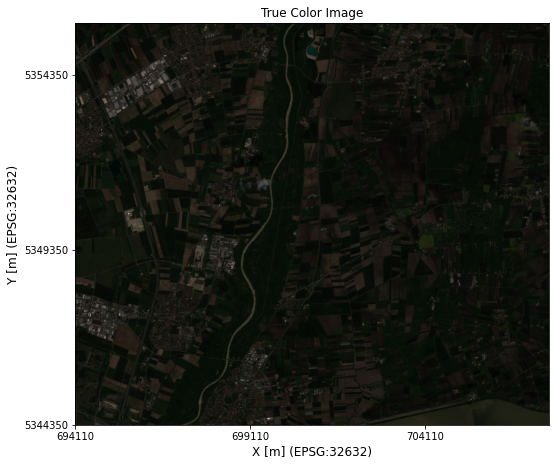

In [77]:
fig_rgb = handler.plot_rgb()

The plot is geo-referenzed, i.e., it shows real (in this case) UTM coordinates on the x and y axis labels.

Another widely used plotting method is the so-called false-color infrared using Sentinel-2 bands B08, B04, and B03 (or: nir_1, red, green):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


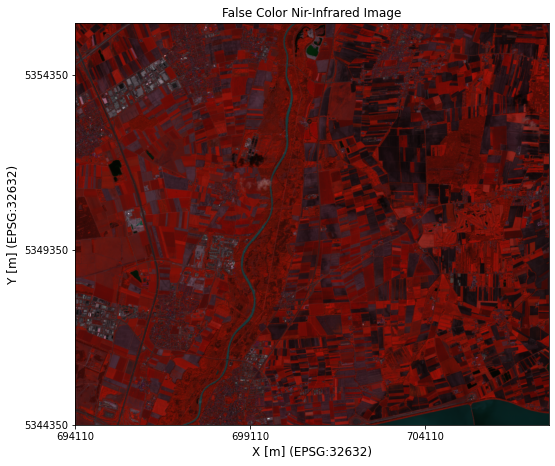

In [78]:
fig_nir = handler.plot_false_color_infrared()

##### Exploring the Data - Scene Classification Layer (SCL)

The SCL layer takes 12 classes and helps to identify clouds, cloud shadows or vegetated areas. The classes have labels between 0 and 11. The official legend can be found [here](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm) (scrawl down).

AgriSatPy's Sentinel2Handler is able to plot the SCL following the official color scheme and providing class labels instead of numbers to make interpretation easier:

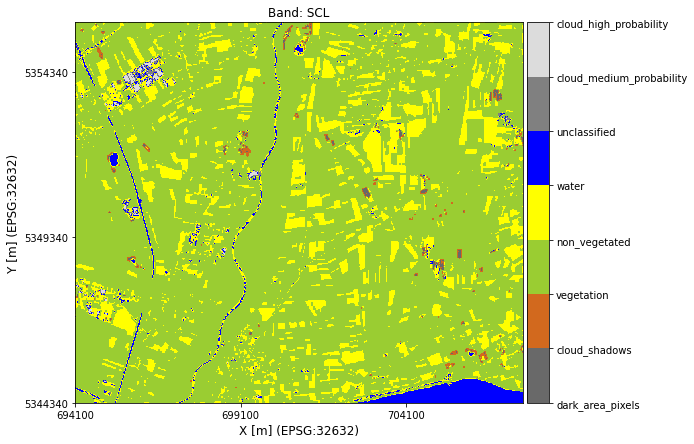

In [79]:
fig_scl = handler.plot_scl()

#### I.3) Calculate the NDVI

For calculating the NDVI, we only need the 10m bands 'red' and 'nir_1'. `AgriSatPy's` Vegetation Index module is designed in a very generic way and automatically selectes the required bands based on their colornames (or raises an error if a required band is not found).

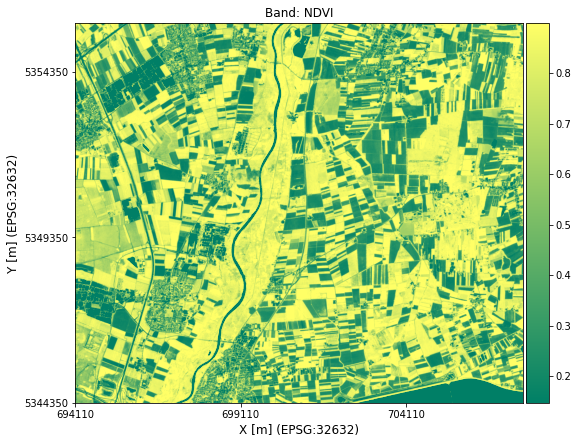

In [80]:
# specify the index name (can be lower or upper case)
vi_name = 'NDVI'

# call the reader's method to calculate indices directly (alternative you can use the VegetationIndices module directly)
handler.calc_vi(vi=vi_name)

fig_ndvi = handler.plot_band(band_name=vi_name, colormap='summer')

While we could calculate the NDVI using 10m bands, only, the TCARI/OSAVI ratio requires resamples of the two red edge bands that come in 20m spatial resolution. For **spatial resampling** we can use the reader's `resample` method that calles `opencv2` in the background.

All we have to do is to specify a target spatial resolution (10m) and select a resampling method supported by opencv2. In this example, we use `bicubic interpolation` in a 4 by 4 pixel neighborhood. The resample method checks then for each band if it has to be resampled (based on the band metadata) and *overwrites* the original entry. The SCL layer is excluded because it requires a different resampling method (nearest neighbor) for discrete classification values.


In [81]:
# our targeted spatial resolution is 10m
target_resolution = 10 # meters

# resample the data but exclude the SCL band since we should not use bicubic interpolation for discrete class values
handler.resample(
    target_resolution=target_resolution,
    resampling_method=cv2.INTER_CUBIC,
    bands_to_exclude=['scl']
)

-------------------
**FYI Resampling of the SCL layer** to 10m spatial resolution using nearest neighbor

------------------

In [82]:
# spatial resolution of the SCL layer BEFORE resampling
scl_res_before = handler.get_spatial_resolution('scl')

handler.resample(
    target_resolution=target_resolution,
    resampling_method=cv2.INTER_NEAREST
)

# spatial resolution of the SCL layer AFTER resampling
scl_res_after = handler.get_spatial_resolution('scl')

print(f'Spatial resolution in x-direction in meters (before/ after): {scl_res_before.x} / {scl_res_after.x}\n' +
     f'Spatial resolution in x-direction in meters (before/ after): {scl_res_before.y} / {scl_res_after.y}')

Spatial resolution in x-direction in meters (before/ after): 20.0 / 10.0
Spatial resolution in x-direction in meters (before/ after): -20.0 / -10.0


Then we can proceed with the calculation of the TCARI/OSAVI ratio (without the resampling of the red edge bands we would get an error here)

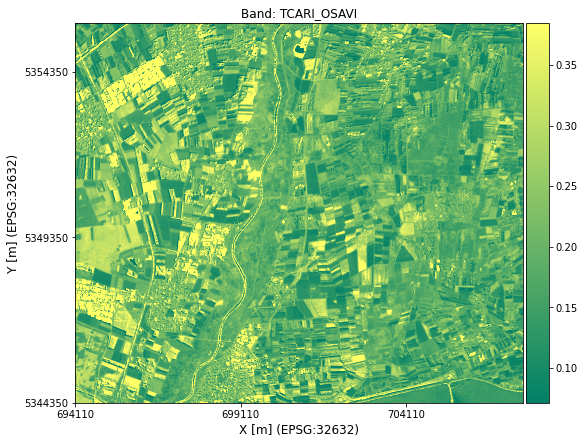

In [83]:
vi_name = 'TCARI_OSAVI'

handler.calc_vi(vi=vi_name)

fig_tcari_osavi = handler.plot_band(band_name=vi_name, colormap='summer')

More vegetation indices are available. You can find the list of currently implemented indices using:

In [84]:
vis = VegetationIndices(handler)
vis.get_vi_list()

['AVI',
 'BSI',
 'CI_green',
 'EVI',
 'MCARI',
 'MSAVI',
 'NDRE',
 'NDVI',
 'TCARI_OSAVI']

### II) Load Data from .SAFE format and apply Cloud Masking

Often it happens that parts of the AOI are covered by clouds and their shadows. Here, cloud masking comes into play. We show how to use `AgriSatPy` and the scene classification layer (SCL) from Sentinel-2 Level-2A data to map clouds in derived image products, such as vegetation indices (see also previous section).

We start with reading the data for a AOI that has some cumulus clouds in it and resample the data - including the SCL layer - to 10m spatial resolution. Then we use the cloud classes in the SCL layer to produce a cloud-masked map of a vegetation index

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


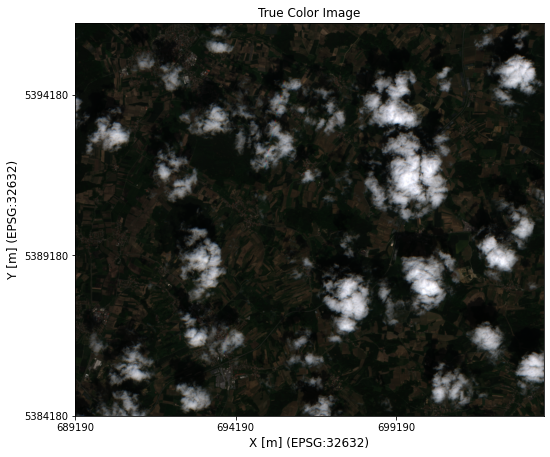

In [85]:
in_file_aoi = Path('../data/sample_polygons/BY_AOI_2019_CLOUDS_EPSG32632.shp')

# get a new reader
handler = Sentinel2Handler()

handler.read_from_safe(
    in_dir=testdata_fname_unzipped,
    in_file_aoi=in_file_aoi,
    band_selection=band_selection
)

# check the RGB
fig_rgb = handler.plot_rgb()

Obviously, this AOI is not cloud-free. This also confirmed by the SCL layer:

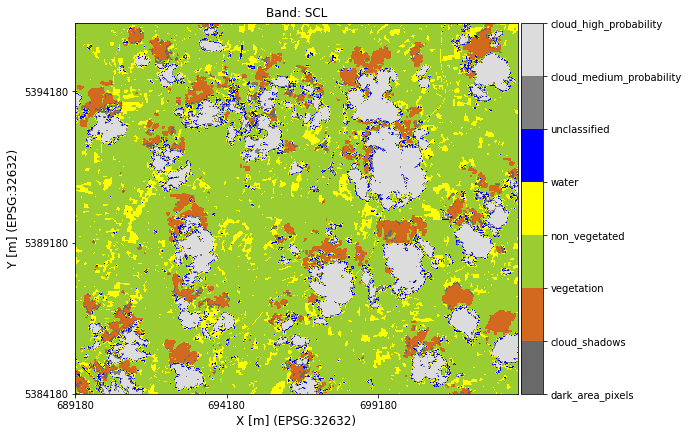

In [86]:
fig_scl = handler.plot_scl()

Using the scene classification we can even quantify the cloud cover in the selected AOI:

In [87]:
print(f'The cloud cover is {np.round(handler.get_cloudy_pixel_percentage(),1)}%')

The cloud cover is 26.9%


We resample the data and calculate the TCARI/OSAVI ratio:

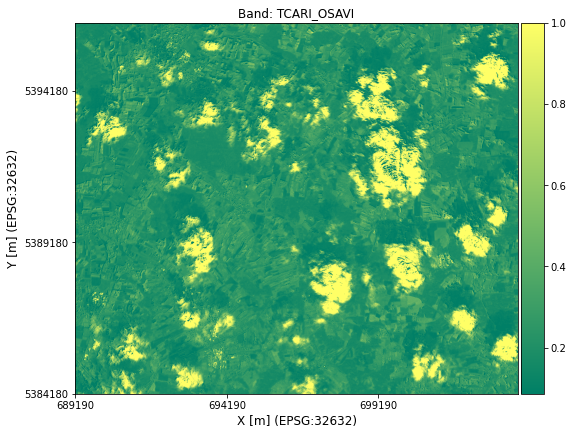

In [88]:
# first resample the spectral bands using bicubic interpolation
handler.resample(
    target_resolution=10,
    resampling_method=cv2.INTER_CUBIC,
    bands_to_exclude=['scl']
)

# and resample then the SCL using nearest neighbour interpolation
handler.resample(target_resolution=10, resampling_method=cv2.INTER_NEAREST)

# calculate the index and map it (still with clouds)
vi_name = 'TCARI_OSAVI'
handler.calc_vi(vi=vi_name)
fig_vi = handler.plot_band(band_name=vi_name, colormap='summer')

With one method call we can get rid of the clouds and set the cloudy pixels to NaN.

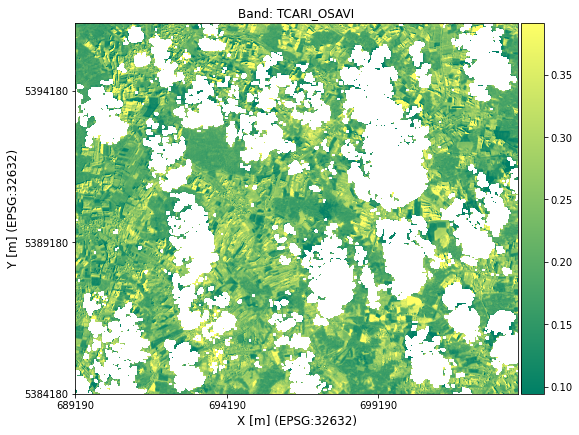

In [89]:
# mask the clouds (SCL classes 8,9,10) and cloud shadows (class 3)
handler.mask_clouds_and_shadows(bands_to_mask=['TCARI_OSAVI'])
fig_vi_cloudfree = handler.plot_band('TCARI_OSAVI', colormap='summer')

#### Save raster dataset to file (geoTiff)

After having finished the index calculation AgriSatPy offers the possibility to write the results back into a geo-referenced image using rasterio in the background. Actually every kind of raster format supported by GDAL can be written but we recommend to use geoTiff (the driver seems to be the most stable one).

The driver is recognized by the file name extension; if your file name ends with `*.tif` the writer method will use GDAL's GeoTiff driver for writing:

In [90]:
# set output file name, existing files are overwritten!
fname_ndvi = testdata_dir.joinpath(f'{vi_name}.tif')

# you can write one or more bands as long as they have the same spatial extent and resolution
handler.write_bands(
    out_file=fname_ndvi,
    band_names=[vi_name]
)   

### II) Load Data from Band-Stacked Sentinel-2 geoTiff File and calculate the NDVI for a List of Field Parcels

Here, we will load a geoTiff file containing Sentinel-2 bands already resampled to 10m spatial resolution using AgriSatPys spatial resampling module. We will then calculate the `Normalized Difference Vegetation Index` (NDVI) and plot it.

In [91]:
# define input data paths
fpath_bandstack = Path('./../data/20190530_T32TMT_MSIL2A_S2A_pixel_division_10m.tiff')
fpath_field_parcels = Path('./../data/sample_polygons/ZH_Polygons_2020_ESCH_EPSG32632.shp')

#### II.1) Reading the Data
In the first step, we read data from geoTiff file (*`fpath_bandstack`* ) using the S2_Band_Reader. The shapefile (*`fpath_field_parcels`* ) specified contains a number of agricultural field parcels. The reader is designed in a way that it only reads the data covering the field polygons using numpy's MaskedArray.

To ensure easy access the data is stored in a dictionary (*`reader.data`* ) whose keys correspond to **Sentinel-2 bands mapped to color-names**. Mapping bands to colornames instead of numbering them, e.g. `B02`, `B03` etc., allows for a more generic data handling and is usually easier for humans to rememeber than a list of abstract numbers.

In [92]:
# get reader object (actually the same class is used as before)
handler = Sentinel2Handler()

# but the read method is now different
handler.read_from_bandstack(
    fname_bandstack=fpath_bandstack,
    in_file_aoi=fpath_field_parcels
)
# check the bands available, we now read all the bands available
handler.get_bandnames()

['blue',
 'green',
 'red',
 'red_edge_1',
 'red_edge_2',
 'red_edge_3',
 'nir_1',
 'nir_2',
 'swir_1',
 'swir_2',
 'scl']

**Spatial resampling** is not required here, since all bands already have the same spatial resolution of 10m. We can check the `meta` information to get the geo-localization of read from the geoTiff file. To do so, we need to access the *`reader.data`* dictionary where all the band data and meta-data is available:

In [93]:
handler.get_meta()

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 221,
 'height': 294,
 'count': 11,
 'crs': CRS.from_epsg(32632),
 'transform': Affine(10.0, 0.0, 475420.0,
        0.0, -10.0, 5256840.0)}

Additionally, the `bounding box` is provided in image coordinates (i.e., UTM). We can access the bounding box using the *`bounds`* item:

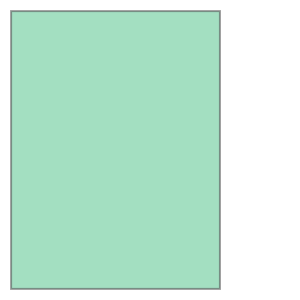

In [94]:
# we can either get a shapely polygon or a rasterio bounding box
handler.get_bounds()

In [95]:
handler.get_bounds(return_as_polygon=False)

BoundingBox(left=475420.0, bottom=5253900.0, right=477630.0, top=5256840.0)

To get an overview, AgriSatPy offers built-in support for true and false color RGB plots:

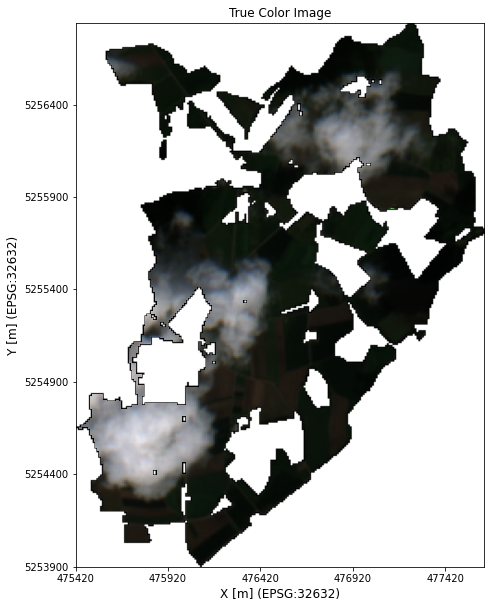

In [96]:
# true color RGB
fig_rgb = handler.plot_rgb()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


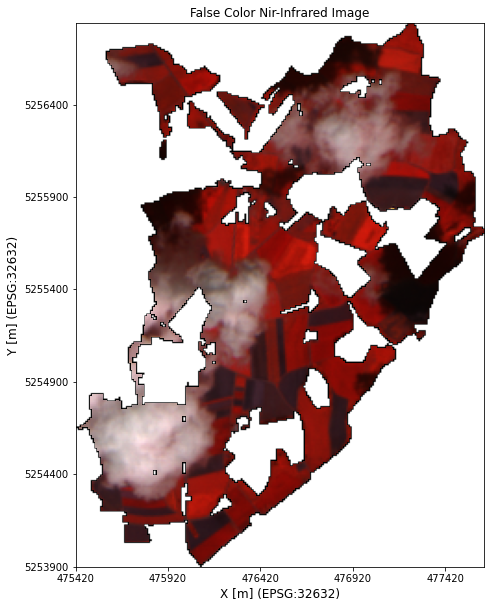

In [97]:
# false color Infrared
fig_nir = handler.plot_false_color_infrared()

Next, we can select one band, e.g., `blue` (you can also use 'B02' instead of the color name) and plot it:

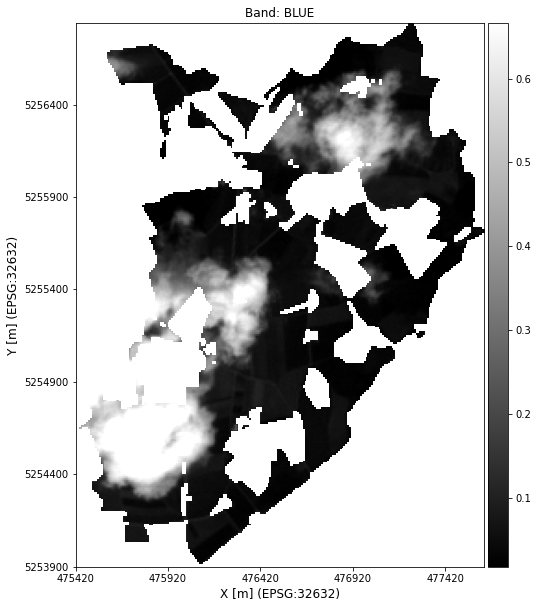

In [98]:
fig_blue = handler.plot_band('blue')

Obviously, also this AOI has some clouds. We can check the SCL layer and calulcate **cloud coverage over the selected field parcels**:

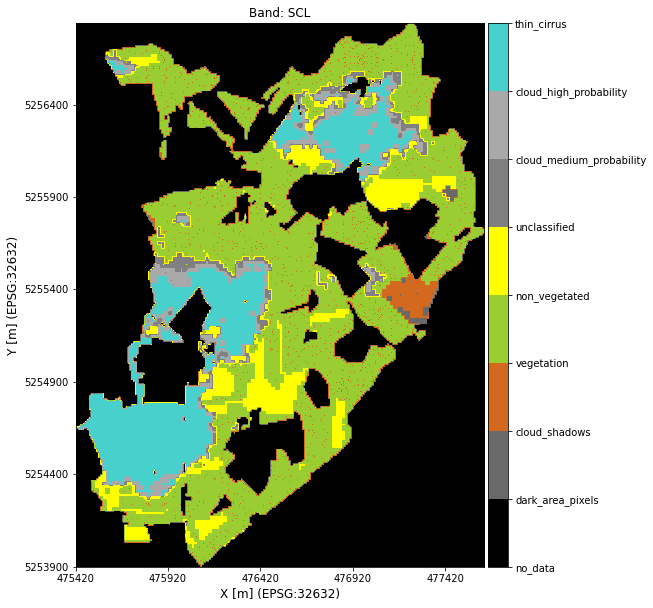

In [99]:
fig_scl = handler.plot_scl()

In [100]:
print(f'The cloudy pixel percentage for the extracted field parcels is {np.round(handler.get_cloudy_pixel_percentage(),2)}%')

The cloudy pixel percentage for the extracted field parcels is 38.99%


#### II.2) Calculating the NDVI

Using the `red` and `nir_1` band we can then plot the NDVI. Since we use the colornames instead of sensor-specific band names, this works theoretically for any sensor having a red and near-infrared band.

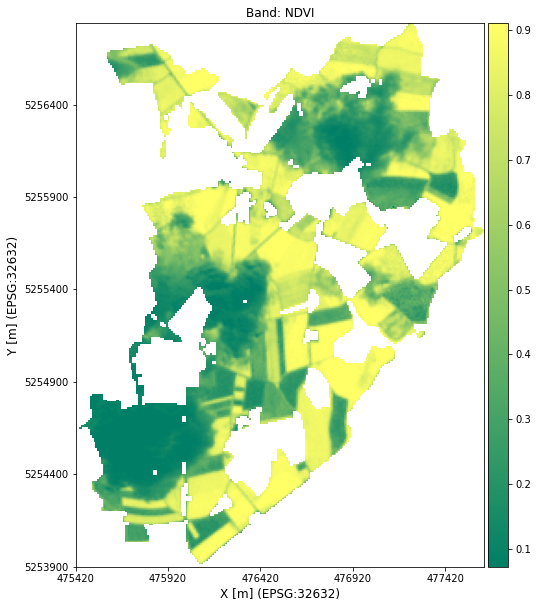

In [101]:
vi_name = 'NDVI'

handler.calc_vi(vi=vi_name)
# plot the NDVI. The method automatically selects the correct bands based on their colorname from the data dict
fig_ndvi = handler.plot_band(band_name=vi_name, colormap='summer')

Since we have clouds, we can **mask** them as well:

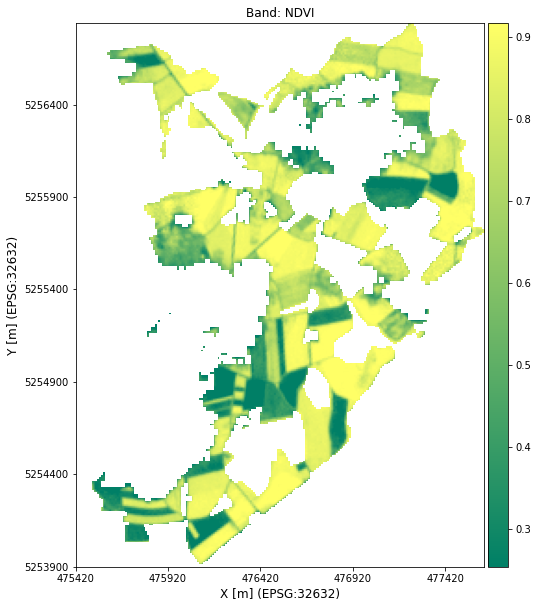

In [102]:
handler.mask_clouds_and_shadows(bands_to_mask=[vi_name])
fig_vi_clouds_masked = handler.plot_band(band_name=vi_name, colormap='summer')

#### II.3) Calculating the NDVI for the entire region covered by the field parcels

In some cases, it might be interesting to have a look at the entire area encompassing the field parcel polygons. The reader class also supports the processing of the entire area encompassing the field parcel geometries specified.

The only thing that is different from the previous steps is the usage of an additional keyword when reading the data:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


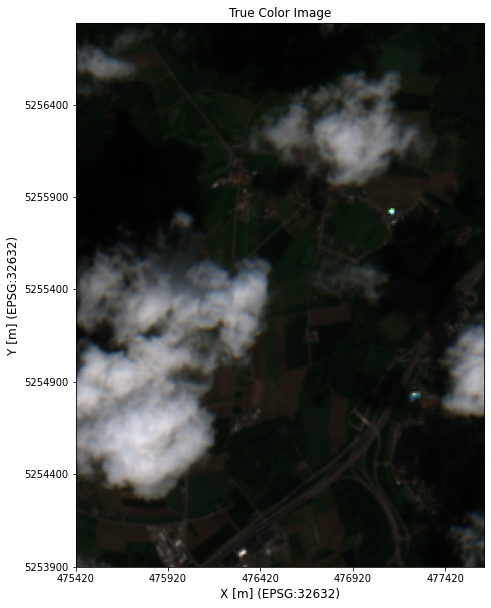

In [103]:
handler = Sentinel2Handler()
handler.read_from_bandstack(
    fname_bandstack=fpath_bandstack,
    in_file_aoi=fpath_field_parcels,
    full_bounding_box_only=True  # set this flag to True 
)

fig_rgb = handler.plot_rgb()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


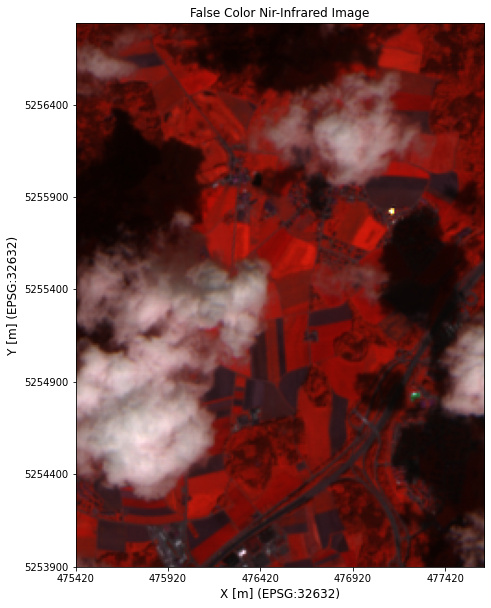

In [104]:
fig_nir = handler.plot_false_color_infrared()

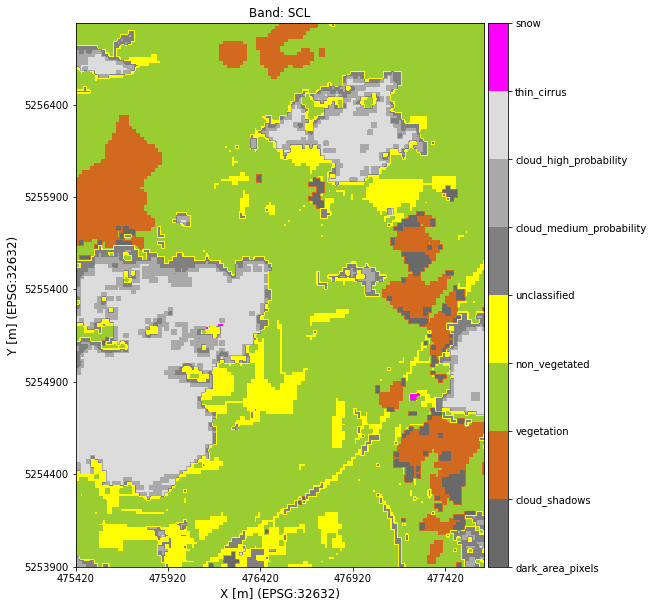

In [105]:
fig_scl = handler.plot_scl()

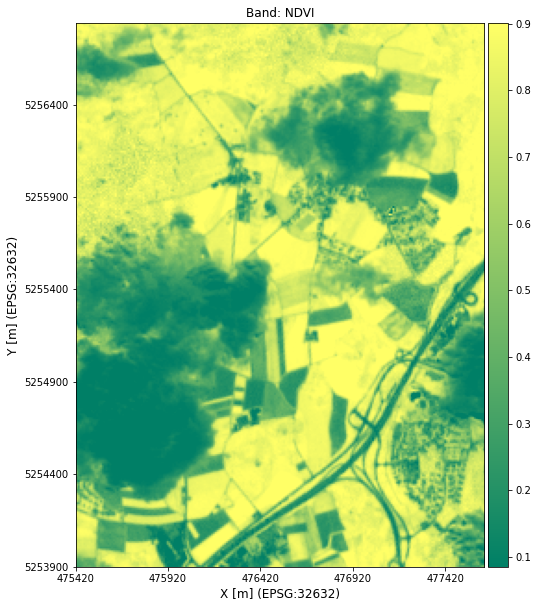

In [106]:
# name is not case-sensitive but it must be consistent
vi_name = 'NDVI'

handler.calc_vi(vi=vi_name)

# plot the NDVI. The method automatically selects the correct bands based on their colorname from the data dict
fig_ndvi = handler.plot_band(band_name=vi_name, colormap='summer')

Mask clouds and cloud shadows:

In [107]:
print(f'The cloud coverage in the AOI is {np.round(handler.get_cloudy_pixel_percentage(), 2)}%')

The cloud coverage in the AOI is 39.67%


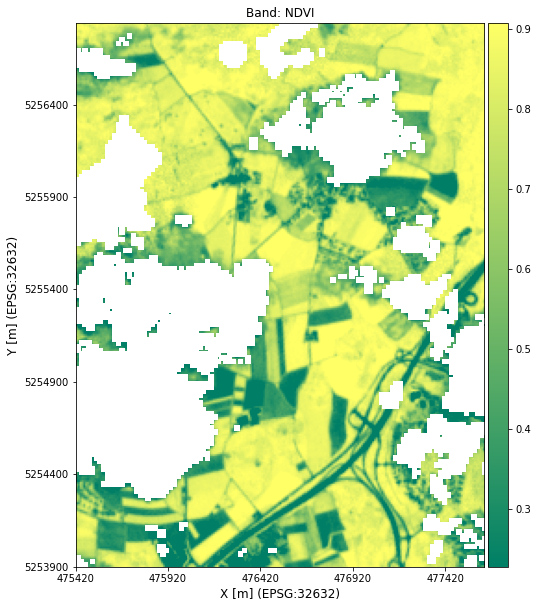

In [108]:
handler.mask_clouds_and_shadows(bands_to_mask=[vi_name])
fig_vi_clouds_masked = handler.plot_band(band_name=vi_name, colormap='summer')